# PYTHON-OPTIMIZATION PROJECT 


###Section 1-Data 





The following program attempt to create the optimal basketball team  of 8 players (consisting of 2 centers, 3 point and shooting guard and 3 small and power forwards) under budget constraint using dynamic programming.




$Maximize:$

$\sum v_ix_i$

$subject $ $ to$

$\sum s_ix_i<budget$

$\sum x_i<desired$ $number$ $of$ $players$

$s_i$ and $v_i$ denotes salary and value\evaluation respectively of player $i$

$x_i\epsilon$ {0,1} $ ∀ i=1,2,3...n$


the data was taken from 

https://www.basketball-reference.com/leagues/NBA_2022_per_game.html

https://www.nbastuffer.com/analytics101/player-impact-estimate-pie/

shown below is the raw data without any munipulation 

In [2]:
import os 
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt


In [3]:
from google.colab import files
uploaded = files.upload()

Saving NBA_playerstats_pergame_r.csv to NBA_playerstats_pergame_r.csv


In [4]:
import io
data = io.BytesIO(uploaded["NBA_playerstats_pergame_r.csv"])
df=pd.read_csv(data,header=0, index_col='Rk')
df.columns
df.head(5)


,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,SALARY
Rk,,,,,,,,,,,,,,,,,,,,,
192,Aaron Gordon,PF,26,DEN,48,48,31.8,5.6,10.9,0.516,...,1.7,3.9,5.6,2.6,0.7,0.6,1.8,1.9,14.6,16409091.0
227,Aaron Henry,SF,22,PHI,6,0,2.8,0.2,0.8,0.200,...,0.0,0.2,0.2,0.0,0.0,0.3,0.3,0.3,0.3,NaN
238,Aaron Holiday,PG,25,WAS,40,13,15.9,2.4,5.1,0.466,...,0.2,1.4,1.6,1.9,0.5,0.2,0.9,1.5,5.9,3980551.0
398,Aaron Nesmith,SF,22,BOS,38,1,10.1,1.2,3.2,0.358,...,0.2,1.4,1.6,0.3,0.3,0.1,0.6,1.2,3.1,3631200.0
395,Abdel Nader,SF,28,PHO,14,0,10.4,0.9,2.5,0.343,...,0.3,1.6,1.9,0.5,0.6,0.3,0.8,1.4,2.4,2000000.0





There are many formulas that will grade each player better and will give the data different weight according to the plyer's position. for the purpose of this project we'll simplify it and  use the following basic formula 

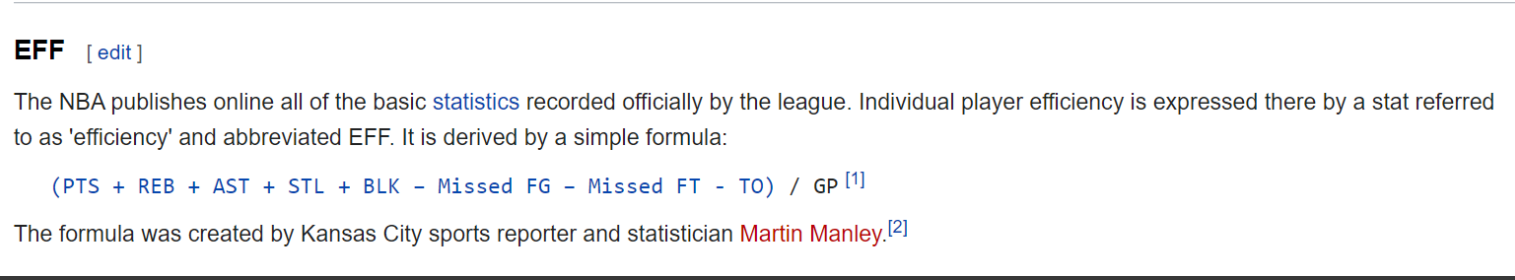

next thing we want to do is arreange the data in a manare that will replace NaN value if nedded and drop players with no game or stats available, and overall create new fixed data frame.

In [5]:

new_df0=df.drop(columns=['GS','Tm','MP','FG%','3P','3PA','3P%','2P','2PA','2P%','eFG%','ORB','DRB','FT%','Age'])
new_df0['MFG']=new_df0['FGA']-new_df0['FG']
new_df0['MFT']=new_df0['FTA']-new_df0['FT']
new_df=new_df0.drop(columns=['FG','FGA','FT','FTA'])
#rarrenge the data frame 
new_df['EVL']=((new_df['PTS']+new_df['TRB']+new_df['AST']+new_df['STL']+new_df['BLK']-new_df['MFT']-new_df['MFG']-new_df['TOV'])/new_df['G'])*100
new_df=new_df.reindex(columns=['Player','Pos','G','PTS','TRB','AST','STL','BLK','MFG','MFT','TOV','EVL','SALARY']).drop_duplicates(subset=['Player'])
#represint Salary in M$
new_df['SALARY']=new_df['SALARY']/1000000
new_df['SALARY'] = new_df['SALARY'].fillna(0)
 
#drop players without enogh data or error like evaluation greater then 100% or less than 0%
indexes=new_df[(new_df['SALARY']==0)& (new_df['G']<10)|(new_df['EVL']>100)|(new_df['EVL']<=0)|(new_df['EVL']>60)&(new_df['SALARY']<15)].index
new_df.drop(indexes,inplace=True)

new_df.head(400)

,Player,Pos,G,PTS,TRB,AST,STL,BLK,MFG,MFT,TOV,EVL,SALARY
Rk,,,,,,,,,,,,,
192,Aaron Gordon,PF,48,14.6,5.6,2.6,0.7,0.6,5.3,0.8,1.8,33.750000,16.409091
238,Aaron Holiday,PG,40,5.9,1.6,1.9,0.5,0.2,2.7,0.2,0.9,15.750000,3.980551
398,Aaron Nesmith,SF,38,3.1,1.6,0.3,0.3,0.1,2.0,0.1,0.6,7.105263,3.631200
395,Abdel Nader,SF,14,2.4,1.9,0.5,0.6,0.3,1.6,0.3,0.8,21.428571,2.000000
244,Al Horford,C,46,10.1,7.5,3.3,0.6,1.3,4.9,0.3,1.0,36.086957,27.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
33,Will Barton,SG,46,15.5,4.9,4.1,0.9,0.5,7.5,0.4,1.9,35.000000,15.384615
96,Willie Cauley-Stein,C,18,1.9,2.1,0.5,0.3,0.2,1.0,0.0,0.4,20.000000,0.000000
229,Willy Hernangómez,C,28,9.2,7.1,1.3,0.4,0.3,3.0,0.7,1.0,48.571429,0.000000


a function to get average stats according to position for calculation later on

In [6]:
def PosAverage(position,stats):
  if(stats=='PTS'):
   pos_average_pts=new_df.loc[new_df['Pos'] ==position, ['Player','PTS']].mean()
   return pos_average_pts
  elif(stats=='SALARY'):
   pos_average_salary=new_df.loc[new_df['Pos'] ==position,['Player','SALARY']].mean()
   return pos_average_salary
  elif(stats=='EVL'):
   pos_average_eval=new_df.loc[new_df['Pos'] ==position,['Player','EVL']].mean()
   return pos_average_eval

average  players evaluation and  salary

In [7]:

print("average players evaluation",new_df['EVL'].mean(),"%")
print("average players salary",new_df['SALARY'].mean(), "M$")

average players evaluation 28.779128824402203 %
average players salary 7.458504267806268 M$


 correlation between evaluation and salary 

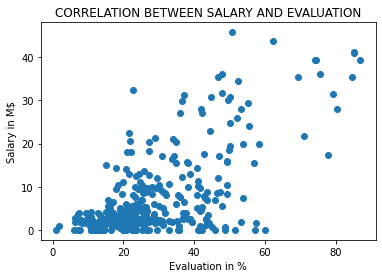

<Figure size 1400x700 with 0 Axes>

In [8]:
from matplotlib.pyplot import subplots, show
a = new_df.EVL
b = new_df.SALARY
fig, ax = subplots()
ax.scatter(a, b)
ax.set_title("CORRELATION BETWEEN SALARY AND EVALUATION")
ax.set_xlabel("Evaluation in %")
ax.set_ylabel("Salary in M$")
fig = plt.figure(dpi=100, figsize=(14, 7))
show()

In the graph we can see that as estimated, EFF  formula is not the best evaluation. even though we dropped players with unreliable stats we do see some 
anomalies,  and many players were over/under estimated. 

In [9]:
correlation_matrix = np.corrcoef(new_df.EVL,new_df.SALARY)
print(correlation_matrix)

[[1.         0.65677758]
 [0.65677758 1.        ]]


but we do see sasticfieng result for the correlation between the variables in the correlation_matrix

### section 2-Data adjustment & converting data frame to a list of players

In [10]:
# convert data frame to a list of dictionaries
players_dict=new_df.to_dict(orient='record')
# print(players_dict)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  


for the purpose of building suitable dp matrix we'll round salary values to an integer or the nearest .5

In [11]:
import math 

def round_SALARY (dict_of_players):
  for player in dict_of_players:
    if (float(player['G'])>10 and float(player['SALARY'])==0):
         player['SALARY']=(PosAverage(player['Pos'],'SALARY')/1000000)
    up=math.ceil(player['SALARY'])
    low=math.floor(player['SALARY'])
    mid=(up+low)/2
    mid1=(mid+up)/2
    mid2=(mid+low)/2
    if (float(player['SALARY'])< 0.25):
      player['SALARY']=0.5
    elif (float(player['SALARY'])< mid2):
     player['SALARY']=low
    elif (float(player['SALARY'])>mid1):
       player['SALARY']=up
    else:
      player['SALARY']=mid

round_SALARY(players_dict)
print(players_dict)

[{'Player': 'Aaron Gordon', 'Pos': 'PF', 'G': 48, 'PTS': 14.6, 'TRB': 5.6, 'AST': 2.6, 'STL': 0.7, 'BLK': 0.6, 'MFG': 5.300000000000001, 'MFT': 0.7999999999999998, 'TOV': 1.8, 'EVL': 33.75, 'SALARY': 16.5}, {'Player': 'Aaron Holiday', 'Pos': 'PG', 'G': 40, 'PTS': 5.9, 'TRB': 1.6, 'AST': 1.9, 'STL': 0.5, 'BLK': 0.2, 'MFG': 2.6999999999999997, 'MFT': 0.20000000000000007, 'TOV': 0.9, 'EVL': 15.750000000000004, 'SALARY': 4}, {'Player': 'Aaron Nesmith', 'Pos': 'SF', 'G': 38, 'PTS': 3.1, 'TRB': 1.6, 'AST': 0.3, 'STL': 0.3, 'BLK': 0.1, 'MFG': 2.0, 'MFT': 0.10000000000000003, 'TOV': 0.6, 'EVL': 7.105263157894736, 'SALARY': 3.5}, {'Player': 'Abdel Nader', 'Pos': 'SF', 'G': 14, 'PTS': 2.4, 'TRB': 1.9, 'AST': 0.5, 'STL': 0.6, 'BLK': 0.3, 'MFG': 1.6, 'MFT': 0.29999999999999993, 'TOV': 0.8, 'EVL': 21.428571428571423, 'SALARY': 2.0}, {'Player': 'Al Horford', 'Pos': 'C', 'G': 46, 'PTS': 10.1, 'TRB': 7.5, 'AST': 3.3, 'STL': 0.6, 'BLK': 1.3, 'MFG': 4.8999999999999995, 'MFT': 0.30000000000000004, 'TOV':

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  


In [16]:
class Player:
  all=[]
  def __init__ (self,Name: str,Pos: str,SALARY,EVAL:float):

    #Assign to self object 
    self.Name=Name
    self.POS=Pos
    self.SALARY=SALARY
    self.EVAL=EVAL

    #create a list of all players 
    Player.all.append(self)
  @classmethod
  def instantiate_from_dict(cls):
      for player in players_dict:
       if (player['EVL']<10 and player['SALARY']==0):
         print("the player",player['Player'], "couldn't been added not enough data ")
         continue
       if (player['G']<10 and player['SALARY']==0):
         print("the player",player['Player'], "couldn't been added not enough data ")
         continue
       if (player['G']>10 and player['SALARY']==0):
         player['SALARY']=(PosAverage(player['Pos'],'SALARY')/1000000)
       Player(
          Name=player['Player'],
          Pos=player['Pos'],
          SALARY=player['SALARY'],
          EVAL=player['EVL'],
          
       )
  def __repr__(self):
    return f"player('{self.Name}',{self.POS},{self.SALARY},{self.EVAL})"


Player.instantiate_from_dict()
# print(Player.all)

function to divide candidates into subgroups by positions

In [17]:


def divide2subgroups(players_list,position):

  group=[]

  Player.all.sort(key=lambda x: x.SALARY)
  #print(Player.all)

  for player in players_list:
      if player.POS == position:
        group.append(player)
  
  return group    
    

### section 3-  create an optimal team  using dynamic programming

In [18]:


def create_subgroup(players_list, budget, players_limitation):

        n = len(players_list)
        dp = np.zeros((n, budget + 1,  players_limitation + 1))

         # for each player given
        for i in range(1, n):
             # For each possible salary
            for j in range(1, budget + 1):
              # For each case where
              # the total number of players is less than the constraint (meaning players_limitation)
              
                for k in range(1, players_limitation + 1):
                  # To ensure that we dont
                  # go out of the array  
                    if (j >= int(2*players_list[i - 1].SALARY)):
                        dp[i][j][k] = max(dp[i - 1][j][k],
                                          dp[i - 1][j - int(2*players_list[i - 1].SALARY)][k - 1] + players_list[i - 1].EVAL)
                    else:
                        dp[i][j][k] = dp[i - 1][j][k]

        #print(dp[-1][-1][-1])
        return dp



def extract_subgroup(player_list, dp):
    n = dp.shape[0]-1
    m = dp.shape[1]-1
    k = dp.shape[2]-1
    max_num_of_players = k

    chosen_players = []
    while(len(chosen_players) < max_num_of_players and k > 0 and m > 0):
        # go backward on player_list (dimension 1) until the value changes - 
        # meaning the player is part of the optimal team
        while(dp[n][m][k] == dp[n-1][m][k]):
            n -= 1

        #append the player to the list
        chosen_players.append(player_list[n-1])

        # go backward on the budget sum (dimension 2) until the value changes -
        # meaning the given budget is neccessary for the optimal team
        while(dp[n][m][k] == dp[n][m-1][k]):
            m-=1

        #get the budget down by the player's salary
        m = m-int(2*player_list[n-1].SALARY)

        #decrease the remaining number of players (dimension 3) to find by 1
        k -= 1
        n -= 1

    return chosen_players
             

In [19]:
# driver code for create & extract subgroups functions
import timeit 

centers=divide2subgroups(Player.all,'C')
print(len(centers))
print(centers)
d_matrix=create_subgroup(centers,7,2)
print(d_matrix)
sub_group=extract_subgroup(centers,d_matrix)
print(sub_group)

t1 = timeit.timeit(lambda: create_subgroup(centers,7,2),number=100) 
t2 = timeit.timeit(lambda: extract_subgroup(centers,d_matrix),number=100) 

print("Avg execution time:",t1+t2)

61
[player('Boban Marjanovi?',C,0.5,26.470588235294112), player('Jusuf Nurki?',C,0.5,41.17647058823529), player('Tacko Fall',C,0.5,23.63636363636364), player('Willie Cauley-Stein',C,0.5,20.0), player('Willy Hernangómez',C,0.5,48.57142857142856), player('DeMarcus Cousins',C,1,48.636363636363626), player('Jock Landale',C,1,18.181818181818183), player('Luka Garza',C,1,21.481481481481485), player('Herbert Jones',C,1.5,25.399999999999995), player('Moses Brown',C,1.5,15.6), player('Vernon Carey Jr.',C,1.5,57.49999999999999), player('Bruno Fernando',C,2,6.31578947368421), player('Chimezie Metu',C,2,30.00000000000001), player('Damian Jones',C,2,26.285714285714285), player('Daniel Gafford',C,2,30.625000000000004), player('Drew Eubanks',C,2,16.25), player('Nemanja Bjelica',C,2,17.75510204081633), player('Nic Claxton',C,2,53.20000000000002), player('Tony Bradley',C,2,17.17948717948718), player('Udoka Azubuike',C,2,43.63636363636365), player('Andre Drummond',C,2.5,29.58333333333333), player('Dwigh

In [20]:
#menu function for main func
def print_menu():
    print("Please select an operation:")
    print("\t0. Exit.")
    print("\t1. Create an optimal team from data")
    print("\t2. Add a player")
    print("\t3. Print team memebers")
   
   

In [21]:
class Team(object):
  def __init__(self, centers, guards, forwards,budget,cost:float):
    self.centers = centers
    self. guards =  guards
    self. forwards =  forwards
    self.budget=budget
    self.cost=cost

 

  def __repr__(self):
   return f'Optimal Team:\n Budget limit:{self.budget}\n Actual budget:{self.cost} \n Centers list:{self.centers}\n Guardslist :{self. guards}\n Forwarda list:{self. forwards}'




In [22]:
  #function to caculate actual total cost of a chosen team
  def calc_cost(group,cost):
    for player in group:
      cost+=player.SALARY
    return cost

In [23]:
 # User interface function for adding a player to the data pool.
 #used in  main func.
import math 


def addPlayer():
  print("Enter player full name")
  name=str(input())
  print(name)
  choice='c'
  while (choice !='1'or choice !='2' or choice !='3' or choice !='4' or choice !='5' or choice !='0'):
    print("Select the position of the player 1.C 2.PG 3.SG 4.SF 5.PF or 0 to Exit")
    choice=input()
    if choice == '1':
     position='C'
     break
    elif choice == '2':
     position='PG' 
     break
    elif choice == '3':
     position='SG' 
     break
    elif choice == '4':
     position='SF'
     break 
    elif choice == '5':
     position='PF'
     break 
    elif choice == '0':
     return
    else:
      print ("unrecognized key try again")
      

  choice ='c'
  print("Does the player have evalution? y/n")
  choice=input()
  if choice == 'y':
    print("press 1 to enter the player evalution per game in % \n")
    print("press 2 to set player evalution to average according to his position")
    option=input()
    if option=='1':
     evaluation=int(input("enter the player evalution per game in %\n"))
     if evaluation==0 or evaluation>100:
      print("player evalution out of range")
      print("The player could not be added to the database")
      return
    elif option=='2':
      evaluation=PosAverage(position,'EVL')
    else:
      print("The player could not be added to the database")
      return
  else:
    print("The player could not be added to the database")
    return
  choice ='c'
  print("Does the Player have estimated salary in recent years? y/n ")
  choice=input()
  if choice == 'y':
    print("press 1 to enter player salary")
    print("press 2 to set player salary to average according to his position")
    option=input()
    if option=="1":
      #salary arbitrary number, non integer or .5 to make sure the user will enter salary as requested
      salary=0.2
      counter=0
      while 2*salary!=math.ceil(2*salary) or salary==0:
        salary=float(input("Enter salary non zero,rounded up to the nearest integer or .5 in M$"))
        counter+=1
        if counter>3:
          print("invalid salary")
          print("The player could not be added to the database")
          return
    elif option=='2':
      salary= PosAverage(position,'SALARY')
  else:
    print("The player could not be added to the database")
    return
  new_player = Player(name,position,salary,evaluation)
  print("The player", new_player, "been added!" )
  print(new_player)


In [24]:

#driver code for addPlayer func
addPlayer()

Enter player full name
Magic Johnson
Magic Johnson
Select the position of the player 1.C 2.PG 3.SG 4.SF 5.PF or 0 to Exit
0


In [ ]:
#driver code for addPlayer func
addPlayer()

In [ ]:
#driver code for addPlayer func
addPlayer()

Enter player full name
Jordan test
Jordan test
Select the position of the player 1.C 2.PG 3.SG 4.SF 5.PF or 0 to Exit
4
Does the player have evalution? y/n
y
press 1 to enter the player evalution per game in % 
press 2 to set player evalution to average according to his position
1
enter the player evalution per game in %90
Does the Player have estimated salary in recent years? y/n 
y
press 1 to enter player salary
press 2 to set player salary to average according to his position
1
Enter salary non zero,rounded up to the nearest integer or .5 in M$2.3
Enter salary non zero,rounded up to the nearest integer or .5 in M$5.7
Enter salary non zero,rounded up to the nearest integer or .5 in M$80.5
The player player('Jordan test',SF,80.5,90) been added!
player('Jordan test',SF,80.5,90)


In [25]:
#global
total_budget=0

In [26]:
# function that handle the process of creating an optimal subgroup.
#get values from the user and calling other functions.



def opti_group(group,players_limitation,positions):
      choice=1
      while choice!='0':
        print("what is your budget for", players_limitation, positions, "in M$?")
        budget = int(input())
        global total_budget
        total_budget+=budget
        dp=create_subgroup(group, budget*2,players_limitation )
        opti_group=extract_subgroup(group,dp)
        print("chosen players are",opti_group)
        if len(opti_group)<players_limitation:
          print("The budget is not enough for the desired number of players, consider increasing the budget")
          print("To continue press 1")
          print("To update budget press 2")
          print("To exit press 0")
          choice=input() 
          if choice==1:
            return opti_group
          elif choice==2:
            total_budget-=budget
            pass
          elif choice==0:
            return Null
        else:
          return opti_group



###section4-main function

In [ ]:
  
def main():
  
   flag=0
   command = 'c'
   while command!='0':
    print_menu()
    command = input()
    if command == '1':
      global total_budget
      total_budget=0
      centers=divide2subgroups(Player.all,'C')
      forwards=divide2subgroups(Player.all,'SF')+divide2subgroups(Player.all,'PF')
      guards=divide2subgroups(Player.all,'PG')+divide2subgroups(Player.all,'SG')
      opti_centers= opti_group(centers,2,'centers')
      if opti_centers==None:
        print("Please try again with a budget other than zero")
        total_budget=0
        continue
      c_cost=calc_cost(opti_centers,0)  
      opti_forwards=opti_group(forwards,3, 'forwards')
      if opti_forwards==None:
        print("Please try again with a budget other than zero")
        total_budget=0
        continue
      else:
        f_cost=calc_cost(opti_forwards,0)
      opti_guards=opti_group(guards,3,'guards')  
      if opti_guards==None:
        print("Please try again with a budget other than zero")
        total_budget=0
        continue
      else:
        g_cost=calc_cost(opti_guards,0)
        opti_cost=c_cost+f_cost+g_cost  
        optimal_team=Team(opti_centers,opti_forwards,opti_guards,total_budget,opti_cost)    
        print("an optimal team has been chosen!")
        flag=1
        continue  
    elif command == '2': 
      addPlayer()    
    elif command == '3':
      if flag==1:
       print(optimal_team)
      else:
        print("create a team first")
    elif command == '0':
      print("Good luck!")
    else:
      print("Error: unrecognized operation.")
      
  



if __name__ == '__main__':
    main()


Please select an operation:
	0. Exit.
	1. Create an optimal team from data
	2. Add a player
	3. Print team memebers
1
what is your budget for 2 centers in M$?
3
chosen players are [player('Vernon Carey Jr.',C,1.5,57.49999999999999), player('DeMarcus Cousins',C,1,48.636363636363626)]
what is your budget for 3 forwards in M$?
5
chosen players are [player('Gabriel Deck',PF,1.5,44.28571428571429), player('Jabari Parker',PF,1,43.33333333333333), player('Mamadi Diakite',PF,0.5,60.0)]
what is your budget for 3 guards in M$?
5
chosen players are [player('Tim Frazier',PG,0.5,45.999999999999986), player('David Duke Jr.',PG,0.5,51.42857142857144), player('Brandon Goodwin',PG,0.5,57.14285714285714)]
an optimal team has been chosen!
Please select an operation:
	0. Exit.
	1. Create an optimal team from data
	2. Add a player
	3. Print team memebers
3
Optimal Team:
 Budget limit:13
 Actual budget:7.0 
 Centers list:[player('Vernon Carey Jr.',C,1.5,57.49999999999999), player('DeMarcus Cousins',C,1,48.6

# section 5-Comparison between dynamic progrmming and the Google OR tool package pywraplp

In [ ]:
import timeit 
# driver code for create & extract subgroups functions 

#short list of players consist of 5 players to see we get 
#the required result and compare 
test_list=Player.all[:5]
print(test_list)
#with this list and a budget of 6M$ and 2 players limitation 
#we expect to see the player 'Bogdan Bogdanovi?' and 'Boban Marjanovi?'
print("test result:")
test_matrix=create_subgroup(test_list,6,2)
sub_group=extract_subgroup(test_list,test_matrix)
print(sub_group)
t11 = timeit.timeit(lambda: create_subgroup(test_list,6,2),number=100)
t12 = timeit.timeit(lambda: extract_subgroup(test_list,test_matrix), number=100)  
print("Avg execution time:",t11+t2)

[player('Alize Johnson',PF,0.5,16.842105263157897), player('Amir Coffey',SG,0.5,23.57142857142857), player('Boban Marjanovi?',C,0.5,26.470588235294112), player('Bogdan Bogdanovi?',SG,0.5,35.7142857142857), player('Bojan Bogdanovi?',PF,0.5,29.607843137254896)]
test result:
[player('Bogdan Bogdanovi?',SG,0.5,35.7142857142857), player('Boban Marjanovi?',C,0.5,26.470588235294112)]
Avg execution time: 0.016478844999994635


In [ ]:

!pip install ortools

     |████████████████████████████████| 15.5 MB 6.7 MB/s 
     |████████████████████████████████| 1.1 MB 56.8 MB/s 
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.17.3
    Uninstalling protobuf-3.17.3:
      Successfully uninstalled protobuf-3.17.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.


In [ ]:

salary_list=[]
value_list=[]

for player in test_list:
  salary_list.append(player.SALARY)
  value_list.append(player.EVAL)
  

In [ ]:
from ortools.linear_solver import pywraplp

def comp_func():
  solver = pywraplp.Solver.CreateSolver('SCIP')

  infinity = solver.infinity()
  #declaring constrains
  x = [solver.IntVar(0.0, infinity, 'x[{}]'.format(i)) for i in range (5)]
  solver.Add(sum(x[i]*salary_list[i] for i in range (len(x)))<=6)
  solver.Add(sum(x[i] for i in range (len(x)))<=2)

  #declaring the veriables binary only
  solver.Add(x[0]>=0)
  solver.Add(x[0]<=1)

  solver.Add(x[1]>=0)
  solver.Add(x[1]<=1)

  solver.Add(x[2]>=0)
  solver.Add(x[2]<=1)

  solver.Add(x[3]>=0)
  solver.Add(x[3]<=1)

  solver.Add(x[4]>=0)
  solver.Add(x[4]<=1)

  #objective function
  solver.Maximize(sum(x[i]*value_list[i] for i in range (len(x))))

  status=solver.Solve()
  print('test 1')
  if status==pywraplp.Solver.OPTIMAL:
    total_cost=sum([x[i].solution_value()*salary_list[i] for i in range (len(x))])
    print('Solution:')
    print("Objective value=",float(solver.Objective().Value()))
    print('total cost',total_cost)
  
    for i in range (len(x)):
     print('x[{}]={}'.format(i, x[i].solution_value()))
     print('chosen players:')
    for i in range (len(x)):
      if(x[i].solution_value()==1.0):
        print(test_list[i].Name)
  else:
      print('the problem does not have an optimal solution')


In [ ]:
comp_func()


test 1
Solution:
Objective value= 65.3221288515406
total cost 1.0
x[0]=-0.0
chosen players:
x[1]=-0.0
chosen players:
x[2]=-0.0
chosen players:
x[3]=1.0
chosen players:
x[4]=1.0
chosen players:
Bogdan Bogdanovi?
Bojan Bogdanovi?


In [ ]:
t22 = timeit.timeit(lambda: comp_func(),number=100)   


In [ ]:
print("Avg execution time:",t22)

Avg execution time: 0.5632357519999687
